<a href="https://colab.research.google.com/github/luizahelenalucena/Cartas-de-Atributo/blob/main/Cartas_de_Atributo_Ex_Livro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cartas de Controle por Atributos (p, np, c,u)**
Exemplo aplicado à Engenharia (inspeção de qualidade)

Disciplina: Controle Estatístico de Processos

Autora: Luiza Helena Oliveira de Lucena - 211038404

Data: Novembro/2025

**1) Importação das bibliotecas**

In [36]:
import pandas as pd #importa a biblioteca Pandas, que é usada para manipulação e análise de dados.
import numpy as np #importa a biblioteca NumPy, voltada para cálculos numéricos e manipulação de arrays (vetores e matrizes).
import matplotlib.pyplot as plt #importa o módulo pyplot da biblioteca Matplotlib, usado para criar gráficos.
#Em todos coloquei o apelido da biblioteca, para encurtar o código.
import scipy # Biblioteca científica para Python que fornece funções matemáticas, estatísticas e de otimização avançadas.
import statsmodels # Biblioteca focada em estatística e econometria, muito usada para modelagem estatística e controle estatístico de processos.
from scipy.stats import binom, poisson # binom: distribuição binomial (usada em cartas p e np)
# poisson: distribuição de Poisson (usada em cartas c e u para defeitos raros)
from statsmodels.stats.proportion import proportion_confint  # útil para comparar com limites clássicos
# Função para calcular intervalos de confiança para proporções,
# útil para comparar com os limites clássicos de cartas p

**2) Dados Embutidos**

In [37]:
dados = {
    "Amostra": list(range(1, 26)),
    "n": [
        100, 80, 80, 100, 110,
        110, 100, 100, 90, 90,
        110, 120, 120, 120, 110,
        80, 80, 80, 90, 100,
        100, 100, 100, 90, 90
    ],
    "Di": [
        12, 8, 6, 9, 10,
        12, 11, 16, 10, 6,
        20, 15, 9, 8, 6,
        8, 10, 7, 5, 8,
        5, 8, 10, 6, 9
    ],
    "p̂i_original": [
        0.12, 0.10, 0.075, 0.09, 0.091,
        0.109, 0.11, 0.16, 0.11, 0.067,
        0.182, 0.125, 0.075, 0.067, 0.055,
        0.10, 0.125, 0.088, 0.056, 0.08,
        0.05, 0.08, 0.10, 0.067, 0.10
    ],
    "LIC_original": [
        0.009, 0, 0, 0.009, 0.012,
        0.012, 0.009, 0.009, 0.003, 0.003,
        0.012, 0.015, 0.015, 0.015, 0.012,
        0, 0, 0, 0.003, 0.009,
        0.009, 0.009, 0.009, 0.003, 0.003
    ],
    "LSC_original": [
        0.183, 0.195, 0.195, 0.183, 0.180,
        0.180, 0.183, 0.183, 0.189, 0.189,
        0.180, 0.177, 0.177, 0.177, 0.180,
        0.195, 0.195, 0.195, 0.189, 0.183,
        0.183, 0.183, 0.183, 0.189, 0.189
    ]
}

df = pd.DataFrame(dados)

**3) Função Auxiliar de Plot (usado por p e np)**

In [38]:
def _plot_carta(x, y, lc, uc, center, ylabel, title, out_of_control_mask):
    plt.figure(figsize=(12, 6))

    # série principal
    plt.plot(x, y, marker="o", linestyle="-", label="Pontos do processo")

    # limites
    plt.plot(x, uc, linestyle="--", label="UCL (Limite Superior de Controle)")
    plt.plot(x, lc, linestyle="--", label="LCL (Limite Inferior de Controle)")

    # linha central
    plt.axhline(center, linestyle="-.", label=f"CL = {center:.4f}")

    # pontos fora de controle
    if out_of_control_mask is not None and out_of_control_mask.any():
        x_out = x[out_of_control_mask]
        y_out = y[out_of_control_mask]
        plt.scatter(
            x_out,
            y_out,
            s=80,
            facecolors="none",
            edgecolors="red",
            label="Fora de controle",
        )

    plt.title(title)
    plt.xlabel("Amostra")
    plt.ylabel(ylabel)
    plt.xticks(x)
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

**4) Carta p – Fração não conforme (usando CEP LIBS)**

In [39]:
def carta_p_cep(df, k=3.0, usar_binomial=False):
    """
    Gera carta p usando:
    - Fórmulas clássicas de 3σ (Montgomery) OU
    - Intervalos binomiais exatos (statsmodels/scipy), se usar_binomial=True.
    """
    df = df.copy()
    x = df["Amostra"]

    # fração não conforme calculada
    df["p_i_calc"] = df["Di"] / df["n"]

    # proporção média global (p-bar)
    p_bar = df["Di"].sum() / df["n"].sum()

    if usar_binomial:
        # Limites via binomial (usando libs de CEP: statsmodels + scipy)
        alpha = 0.0027  # ~ equivalente a 3σ
        lcls = []
        ucls = []

        for n_i in df["n"]:
            # número esperado de não conformes sob p_bar
            d_esp = int(round(p_bar * n_i))

            low, up = proportion_confint(
                count=d_esp,
                nobs=int(n_i),
                alpha=alpha,
                method="beta"  # Clopper–Pearson (exato binomial)
            )
            lcls.append(max(low, 0.0))
            ucls.append(min(up, 1.0))

        df["LCL_calc"] = lcls
        df["UCL_calc"] = ucls
    else:
        # Limites 3σ (aproximação normal da binomial)
        df["sigma_pi"] = np.sqrt(p_bar * (1 - p_bar) / df["n"])
        df["UCL_calc"] = p_bar + k * df["sigma_pi"]
        df["LCL_calc"] = (p_bar - k * df["sigma_pi"]).clip(lower=0.0)

    # pontos fora de controle
    df["ForaControle"] = (
        (df["p_i_calc"] > df["UCL_calc"]) |
        (df["p_i_calc"] < df["LCL_calc"])
    )

    # -------- PRINTS IMPORTANTES --------
    print("\n================ CARTA p (Fração não conforme) ================")
    print(f">> p̄ (fração média não conforme) = {p_bar:.5f}")

    print("\n>> Resumo (primeiras 10 amostras):")
    print(df[[
        "Amostra", "n", "Di",
        "p_i_calc", "p̂i_original",
        "LCL_calc", "LIC_original",
        "UCL_calc", "LSC_original",
        "ForaControle"
    ]].head(10))

    print("\n>> Pontos fora de controle (carta p):")
    fora = df[df["ForaControle"] == True]
    if fora.empty:
        print("Nenhum ponto fora de controle.")
    else:
        print(fora[["Amostra", "n", "Di", "p_i_calc", "LCL_calc", "UCL_calc"]])

    # -------- GRÁFICO --------
    _plot_carta(
        x=x,
        y=df["p_i_calc"],
        lc=df["LCL_calc"],
        uc=df["UCL_calc"],
        center=p_bar,
        ylabel="Fração não conforme (pᵢ)",
        title="Carta p – Fração não conforme (atributos)",
        out_of_control_mask=df["ForaControle"],
    )

    return df, p_bar


In [40]:
def carta_np_cep(df, p_bar=None, k=3.0):
    """
    Carta np usando o mesmo conjunto de dados.
    Assumimos n ≈ constante e usamos n̄.

    Fórmulas (Montgomery):
        np̄ = n̄ p̄
        σ_np = sqrt(n̄ p̄ (1 - p̄))
        UCL = np̄ + k σ_np
        LCL = max(0, np̄ - k σ_np)
    """
    df = df.copy()
    x = df["Amostra"]

    # se p̄ não for passado, calculamos a partir dos dados
    if p_bar is None:
        p_bar = df["Di"].sum() / df["n"].sum()

    n_bar = df["n"].mean()  # tamanho médio da amostra

    np_bar = n_bar * p_bar
    sigma_np = np.sqrt(n_bar * p_bar * (1 - p_bar))

    ucl = np_bar + k * sigma_np
    lcl = max(0.0, np_bar - k * sigma_np)

    df["np_i"] = df["Di"]
    df["UCL_np"] = ucl
    df["LCL_np"] = lcl
    df["ForaControle_np"] = (df["np_i"] > ucl) | (df["np_i"] < lcl)

    # -------- PRINTS IMPORTANTES --------
    print("\n================ CARTA np (Nº não conformes) ================")
    print(f">> n̄ (tamanho médio de amostra) = {n_bar:.2f}")
    print(f">> p̄ (fração média não conforme) = {p_bar:.5f}")
    print(f">> np̄ = {np_bar:.3f}")
    print(f">> UCL = {ucl:.3f} | LCL = {lcl:.3f}")

    print("\n>> Resumo (primeiras 10 amostras):")
    print(df[[
        "Amostra", "n", "Di", "np_i",
        "LCL_np", "UCL_np", "ForaControle_np"
    ]].head(10))

    print("\n>> Pontos fora de controle (carta np):")
    fora = df[df["ForaControle_np"] == True]
    if fora.empty:
        print("Nenhum ponto fora de controle.")
    else:
        print(fora[["Amostra", "n", "np_i", "LCL_np", "UCL_np"]])

    # -------- GRÁFICO --------
    # Aqui os limites são constantes (não variam com a amostra)
    plt.figure(figsize=(12, 6))

    plt.plot(x, df["np_i"], marker="o", linestyle="-", label="npᵢ (nº não conformes)")
    plt.axhline(np_bar, linestyle="-.", label=f"np̄ = {np_bar:.3f}")
    plt.axhline(ucl, linestyle="--", label=f"UCL = {ucl:.3f}")
    plt.axhline(lcl, linestyle="--", label=f"LCL = {lcl:.3f}")

    if not fora.empty:
        plt.scatter(
            fora["Amostra"],
            fora["np_i"],
            s=80,
            facecolors="none",
            edgecolors="red",
            label="Fora de controle",
        )

    plt.title("Carta np – Número de unidades não conformes (atributos)")
    plt.xlabel("Amostra")
    plt.ylabel("Número de não conformes (npᵢ)")
    plt.xticks(x)
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df, np_bar




================ CARTA p (Fração não conforme) ================
>> p̄ (fração média não conforme) = 0.09551

>> Resumo (primeiras 10 amostras):
   Amostra    n  Di  p_i_calc  p̂i_original  LCL_calc  LIC_original  UCL_calc  \
0        1  100  12  0.120000         0.120  0.007335         0.009  0.183686   
1        2   80   8  0.100000         0.100  0.000000         0.000  0.194093   
2        3   80   6  0.075000         0.075  0.000000         0.000  0.194093   
3        4  100   9  0.090000         0.090  0.007335         0.009  0.183686   
4        5  110  10  0.090909         0.091  0.011438         0.012  0.179582   
5        6  110  12  0.109091         0.109  0.011438         0.012  0.179582   
6        7  100  11  0.110000         0.110  0.007335         0.009  0.183686   
7        8  100  16  0.160000         0.160  0.007335         0.009  0.183686   
8        9   90  10  0.111111         0.110  0.002565         0.003  0.188455   
9       10   90   6  0.066667         0.067  

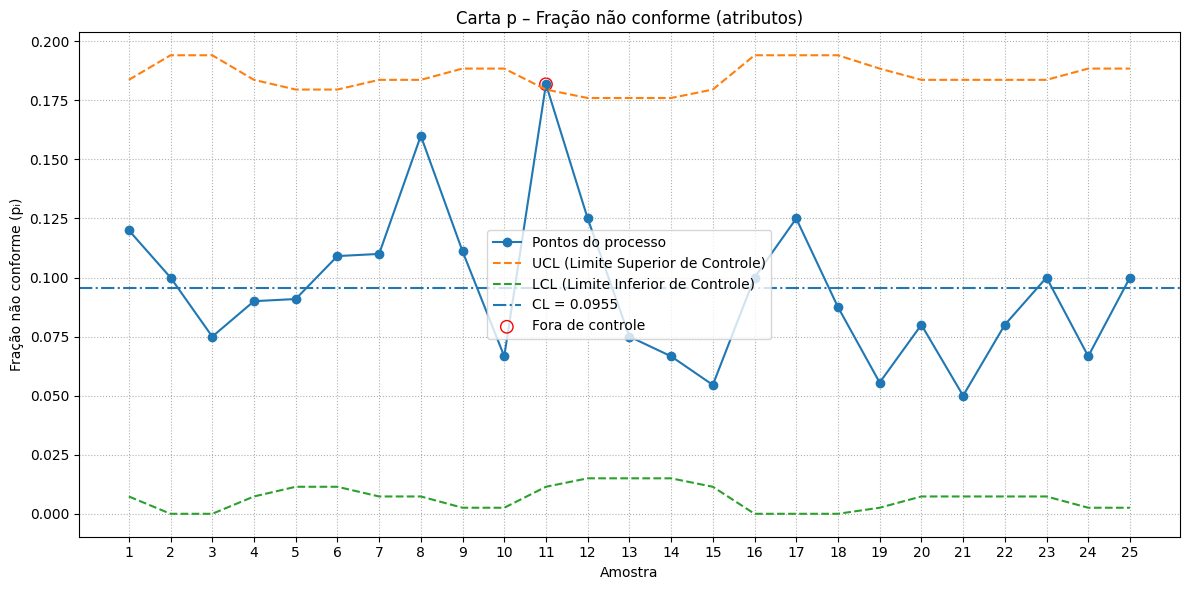


================ CARTA np (Nº não conformes) ================
>> n̄ (tamanho médio de amostra) = 98.00
>> p̄ (fração média não conforme) = 0.09551
>> np̄ = 9.360
>> UCL = 18.089 | LCL = 0.631

>> Resumo (primeiras 10 amostras):
   Amostra    n  Di  np_i   LCL_np    UCL_np  ForaControle_np
0        1  100  12    12  0.63107  18.08893            False
1        2   80   8     8  0.63107  18.08893            False
2        3   80   6     6  0.63107  18.08893            False
3        4  100   9     9  0.63107  18.08893            False
4        5  110  10    10  0.63107  18.08893            False
5        6  110  12    12  0.63107  18.08893            False
6        7  100  11    11  0.63107  18.08893            False
7        8  100  16    16  0.63107  18.08893            False
8        9   90  10    10  0.63107  18.08893            False
9       10   90   6     6  0.63107  18.08893            False

>> Pontos fora de controle (carta np):
    Amostra    n  np_i   LCL_np    UCL_np
10     

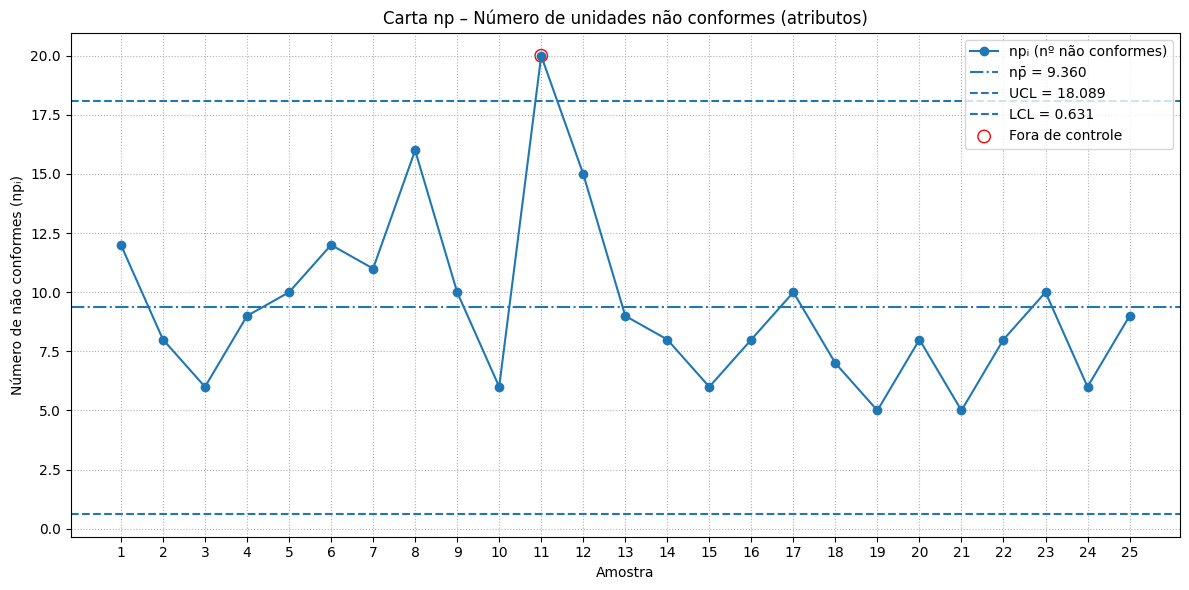


>>> Concluído: carta p e carta np geradas com bibliotecas de CEP (scipy, statsmodels).


In [41]:
if __name__ == "__main__":
    # Carta p com CEP libs (3σ; se quiser binomial exato, usar usar_binomial=True)
    df_p, p_bar = carta_p_cep(df, k=3.0, usar_binomial=False)

    # Carta np usando o mesmo p̄ estimado na carta p
    df_np, np_bar = carta_np_cep(df, p_bar=p_bar, k=3.0)

    print("\n>>> Concluído: carta p e carta np geradas com bibliotecas de CEP (scipy, statsmodels).")
